# Hello Hello !
## in this notebook we will apply some of  the ensemble techniques like : 
- Boosting
- Bagging
- Stacking
## on the famous MNIST digits dataset !

## 1st let's load the dataset

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = r"/kaggle/input/mnist-in-csv/mnist_train.csv" 

df = pd.read_csv(path)

# EDA

### Now let's explore the data 🧐

In [3]:
df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### So we have 60k rows and 784 feature (28x28 pixels but flattened) and 1 label column

In [4]:
df['label'].value_counts()

label
1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: count, dtype: int64

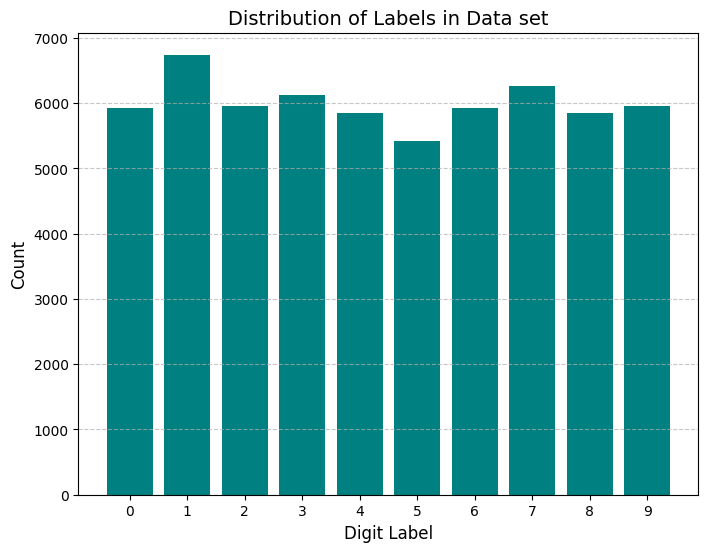

In [24]:

label_counts = df['label'].value_counts().sort_index()

plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, color='teal')
plt.title('Distribution of Labels in Data set', fontsize=14)
plt.xlabel('Digit Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(ticks=range(10), labels=[str(i) for i in range(10)])
plt.grid(True, axis='y', linestyle='--', alpha=0.7) 
plt.show()

### Great there's not any severe imbalance so we're good till now

## Now let's make a function to see some samples of the images !

In [5]:
def show_image(data, num_samples=5, random_seed=None, indices=None):
    """
    Plot a grid of MNIST digit images with their labels.
    
    Args:
        data (pd.DataFrame): MNIST dataset with 'label' and pixel columns.
        num_samples (int): Number of samples to display (if indices not provided).
        random_seed (int, optional): Seed for reproducibility.
        indices (list, optional): Specific row indices to plot.
    """
    # Select indices to plot
    if indices is None:
        if random_seed is not None:
            np.random.seed(random_seed)
        indices = np.random.choice(data.index, size=num_samples, replace=False)
    else:
        num_samples = len(indices)
    
    samples = data.loc[indices]
    
    # Set up the plot
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
    if num_samples == 1:
        axes = [axes]  # Handle single plot case
    
    for i, (idx, row) in enumerate(samples.iterrows()):
        # Extract label and pixels
        label = row['label']
        pixels = row.drop('label').values  # 784 pixels
        image = pixels.reshape(28, 28)    # Reshape to 28x28
        
        # Plot the image
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

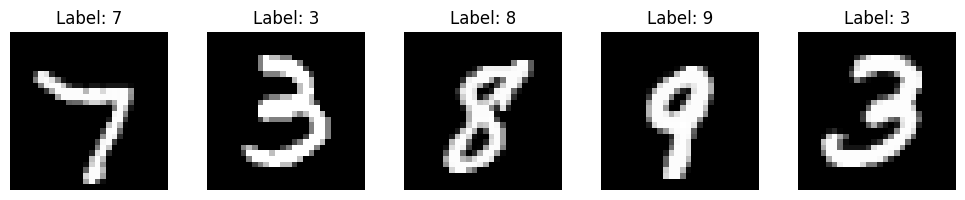

In [6]:
show_image(df , num_samples = 5 , random_seed = 42)

### Let's check pixel values it should be ranging from 0 (min) to 255 (max)

In [7]:
print("Min Pixel Value:", df.iloc[:, 1:].min().min()) 
print("Max Pixel Value:", df.iloc[:, 1:].max().max())

Min Pixel Value: 0
Max Pixel Value: 255


 #### Missing values ? 

In [35]:
sum(df.isna().sum())

0

#### Duplicates ? 

In [39]:
df.duplicated().sum()

0

## Pre-Processing

### I'll just normalize the data and that's enough for now 

In [8]:
from sklearn.model_selection import train_test_split

X = df.drop(['label'], axis= 1)
y = df['label']

X_train , X_test , y_train , y_test = train_test_split(X,y , stratify = y , test_size = 0.3 , random_state = 42)

In [9]:
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((42000, 784), (18000, 784), (42000,), (18000,))

In [10]:
# Normalize the train data (this will scale the pixel values to range between 0 and 1)

X_train = X_train / 255.0
X_test = X_test / 255.0

## Modeling

### Bagging

In [45]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Create a Bagging model using Decision Tree
bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(),  # Base model (Decision Tree)
    n_estimators=10,  # Number of estimators (trees)
    max_samples=0.8,  # Percentage of data used per model
    bootstrap=True,  # Enable bootstrapping (sampling with replacement)
    random_state=42
)

In [46]:
bagging_model.fit(X_train , y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=0.8,
                  random_state=42)

In [48]:
print(bagging_model.score(X_train , y_train))

0.9966904761904762


### Bagging Predictions

In [49]:
bagging_pred = bagging_model.predict(X_test)

In [50]:
bagging_model.score(X_test , y_test)

0.9393333333333334

In [18]:
from sklearn.metrics import classification_report , confusion_matrix


In [ ]:
print(classification_report(y_test, bagging_pred, target_names=[str(i) for i in range(10)]))

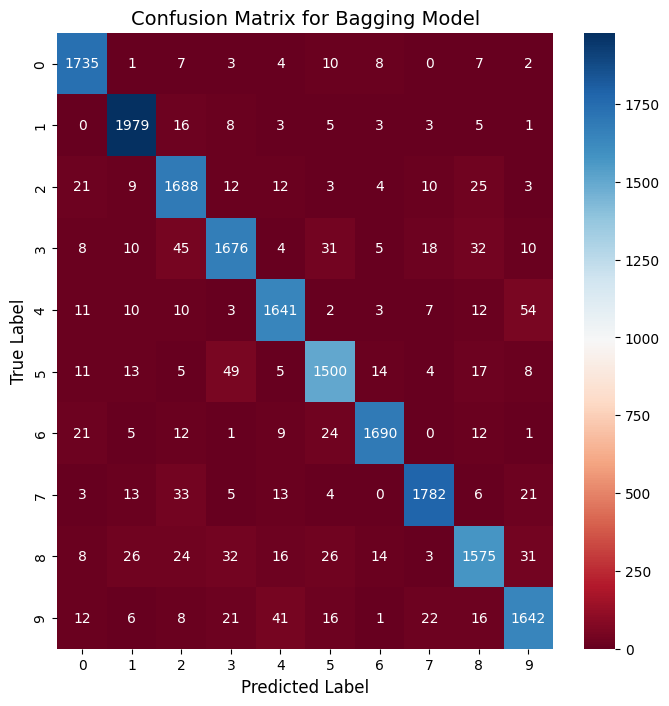

In [77]:
conf_matrix = confusion_matrix(y_test, bagging_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='RdBu')
plt.title('Confusion Matrix for Bagging Model', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

## Boosting

In [11]:
from xgboost import XGBClassifier

# Create XGBoost classifier
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.01,  
    max_depth=6,    
    random_state=42,
    subsample= 0.8,
    n_jobs=-1,                
    eval_metric="mlogloss"
)

In [12]:
xgb_model.fit(X_train , y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, objective='multi:softprob', ...)

In [13]:
xgb_model.score(X_train , y_train)

0.9421904761904762

In [14]:
xgb_model.score(X_test , y_test)

0.9203888888888889

## Boosting Predictions

In [15]:
boosting_pred = xgb_model.predict(X_test)

In [19]:
print(classification_report(y_test, boosting_pred, target_names=[str(i) for i in range(10)]))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1777
           1       0.95      0.97      0.96      2023
           2       0.92      0.91      0.92      1787
           3       0.92      0.89      0.90      1839
           4       0.92      0.92      0.92      1753
           5       0.92      0.87      0.90      1626
           6       0.95      0.92      0.94      1775
           7       0.93      0.92      0.93      1880
           8       0.88      0.90      0.89      1755
           9       0.85      0.91      0.88      1785

    accuracy                           0.92     18000
   macro avg       0.92      0.92      0.92     18000
weighted avg       0.92      0.92      0.92     18000



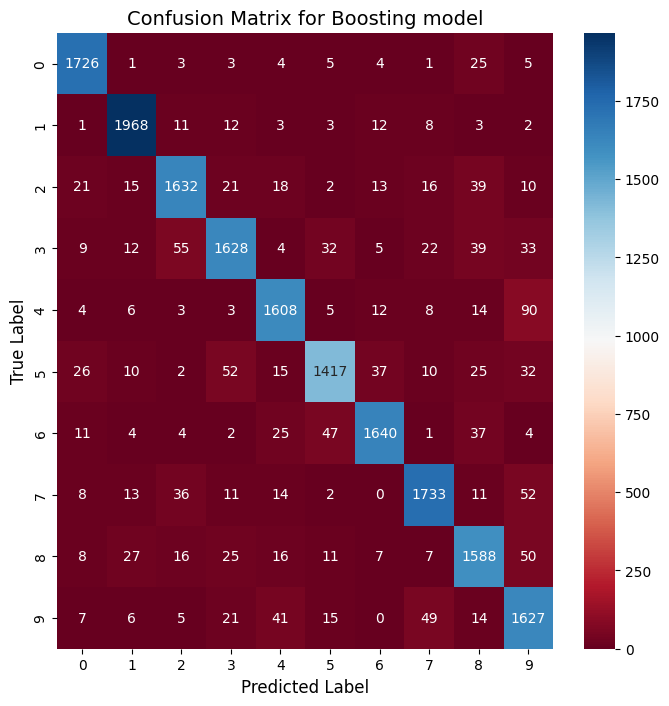

In [20]:
conf_matrix = confusion_matrix(y_test, boosting_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='RdBu')
plt.title('Confusion Matrix for Boosting model', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

## Stacking

In [21]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


base_models = [
    ('rf', RandomForestClassifier(n_estimators=10, max_depth=6, random_state=42, n_jobs=-1)),
    ('xgb', XGBClassifier(n_estimators=10, learning_rate=0.01, max_depth=6, random_state=42, eval_metric="mlogloss", n_jobs=-1)),
    ('svm', SVC(kernel='rbf', C=1, gamma='scale', probability=True, random_state=42))
]


meta_model = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42)


stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,     
    n_jobs=-1,        # Parallelize training
    verbose=1         # Show progress
)

In [22]:
stacking_model.fit(X_train , y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.2s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.6min finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 31.2min finished


StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=6,
                                                       n_estimators=10,
                                                       n_jobs=-1,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='mlogloss',
                                              feature_types=N...
                                              max_delta_step=None, max_depth=6,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=10, n_jobs=-1,
                                              num_parallel_tree=None,
                                              random_state=42, ...)),
                               ('svm',
                                SVC(C=1, probability=True, random_state=42))],
                   final_estimator=LogisticRegression(max_iter=1000,
                                                      multi_class='multinomial',
                                                      random_state=42),
                   n_jobs=-1, verbose=1)

In [23]:
stacking_model.score(X_train , y_train)

0.9891904761904762

In [24]:
stacking_model.score(X_test , y_test)

0.9773333333333334

## Stacking Predictions

In [25]:
stacking_pred = stacking_model.predict(X_test)

In [26]:
print(classification_report(y_test, stacking_pred, target_names=[str(i) for i in range(10)]))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1777
           1       0.98      0.99      0.99      2023
           2       0.97      0.98      0.98      1787
           3       0.98      0.96      0.97      1839
           4       0.98      0.98      0.98      1753
           5       0.98      0.98      0.98      1626
           6       0.99      0.98      0.99      1775
           7       0.98      0.97      0.98      1880
           8       0.97      0.97      0.97      1755
           9       0.96      0.97      0.97      1785

    accuracy                           0.98     18000
   macro avg       0.98      0.98      0.98     18000
weighted avg       0.98      0.98      0.98     18000



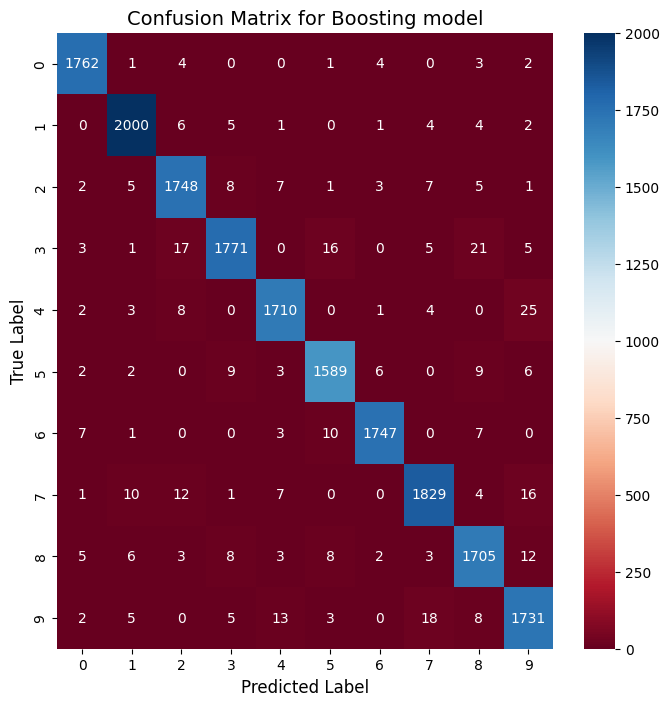

In [27]:
conf_matrix = confusion_matrix(y_test, stacking_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='RdBu')
plt.title('Confusion Matrix for Boosting model', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

### Comparing between the models

In [ ]:
from sklearn.metrics import accuracy_score

stacking_acc = accuracy_score(y_test , stacking_pred)
boosting_acc = accuracy_score(y_test , boosting_pred)
bagging_acc  = accuracy_score(y_test , bagging_pred)


# Calculate accuracies
accuracies = {
    'Stacking': accuracy_score(y_test, stacking_pred),
    'Boosting': accuracy_score(y_test, boosting_pred),
    'Bagging': accuracy_score(y_test, bagging_pred)
}

# Convert to DataFrame for Seaborn
df = pd.DataFrame(list(accuracies.items()), columns=['Model', 'Accuracy'])

# Plot
plt.figure(figsize=(8, 8))
sns.barplot(x='Model', y='Accuracy', data=df, palette='viridis')

# Customize the plot
plt.title('Model Accuracy Comparison', fontsize=15)
plt.ylim(0, 1.0)  # Since accuracy is between 0 and 1
plt.xlabel('Model Type', fontsize=12)
plt.ylabel('Accuracy Score', fontsize=12)

# Add value labels on top of bars
for index, row in df.iterrows():
    plt.text(index, row['Accuracy'], f"{row['Accuracy']:.3f}", 
             ha='center', va='bottom', fontsize=12)

plt.show()

# Saving the Models for future Predictions

In [83]:
import pickle

# bagging
with open('bagging_model.pkl', 'wb') as file:
    pickle.dump(bagging_model, file)

In [30]:
import pickle

In [32]:
# boosting
with open('boosting_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)

In [31]:
# Stacking
with open('stacking_model.pkl', 'wb') as file:
    pickle.dump(stacking_model, file)

In [39]:
import joblib

joblib.dump(stacking_model, 'model.pkl')

['model.pkl']

## Prediction pipeline

In [35]:
def load_model(path):

    # Load it from the file
    with open(path , 'rb') as file:
        loaded_model = pickle.load(file)

    return loaded_model

In [34]:
from PIL import Image

def make_prediction(model , img_path):
    # Load and preprocess the image
    img = Image.open(img_path).convert('L')  
    img = img.resize((28, 28))
    img_array = np.array(img)
    
    img_array = img_array / 255.0              
    img_flat = img_array.flatten()             
    img_flat = img_flat.reshape(1, -1)


    if model == 1:
        file_path = 'bagging_model.pkl'
    elif model == 2:
        file_path = 'boosting_model.pkl'
    else:
        file_path = 'stacking_model.pkl'


    model = load_model(file_path)

    pred = model.predict(img_flat)


    return int(pred[0])    

In [36]:
print(make_prediction(3 ,r'/kaggle/input/images-test/337.png'))

7


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
